In [1]:
using RxInfer, Distributions, Random, GraphPlot, Cairo, MetaGraphsNext, GraphPPL, GraphViz, Dictionaries, Plots, StableRNGs, LinearAlgebra, StatsPlots, LaTeXStrings, DataFrames, CSV, GLM

# Coin-toss Model

In this example, we are going to perform an exact inference for a coin-toss model that can be represented as:

\begin{align}
    p(\theta) &= \text{Beta}(\theta | a, b)\\
    p(y_i | \theta) &= \text{Bernoulli}(y_i | \theta)
\end{align}

Where $y_i \in \{0, 1\}$ is a binary observation induced by Bernoulli likelihood while $\theta$ is a Beta prior distribution on the parameter of the Bernoulli Likelihood. We are interested in inferring the posterior distribution of $\theta$.

The joint probability is given by the multiplication of the likelihood and the prior, i.e.

\begin{equation}
    p(y_{1:N}, \theta) = p(\theta) \prod_{i=1}^{N} p(y_i | \theta)
\end{equation}

We can specify this model (the joint distribution) using GraphPPL's package syntax.

In [2]:
# GraphPPL.jl export `@model` macro for model specification
# It accepts a regular Julia function and builds an FFG under the hood
@model function coin_model(y, a, b)
    # We endow θ parameter of our model with some prior
    θ ~ Beta(a, b)
    # or, in this particular case, the `Uniform(0.0, 1.0)` prior also works:
    # θ ~ Uniform(0.0, 1.0)

    # We assume that outcome of each coin flip is governed by the Bernoulli distribution
    for i in eachindex(y)
        y[i] ~ Bernoulli(θ)
    end
end

In [3]:
conditioned = coin_model(a = 2.0, b = 7.0) | (y = [ true, false, true ], )

coin_model(a = 2.0, b = 7.0) conditioned on: 
  y = Bool[1, 0, 1]


In [4]:
# `Create` the actual graph of the model conditioned on the data
rxi_model = RxInfer.create_model(conditioned)

ProbabilisticModel{GraphPPL.Model{MetaGraph{Int64, Graphs.SimpleGraphs.SimpleGraph{Int64}, GraphPPL.NodeLabel, GraphPPL.NodeData, GraphPPL.EdgeLabel, GraphPPL.Context, MetaGraphsNext.var"#4#8", Float64}, GraphPPL.PluginsCollection{Tuple{}}, RxInfer.ReactiveMPGraphPPLBackend}}(GraphPPL.Model{MetaGraph{Int64, Graphs.SimpleGraphs.SimpleGraph{Int64}, GraphPPL.NodeLabel, GraphPPL.NodeData, GraphPPL.EdgeLabel, GraphPPL.Context, MetaGraphsNext.var"#4#8", Float64}, GraphPPL.PluginsCollection{Tuple{}}, RxInfer.ReactiveMPGraphPPLBackend}(Meta graph based on a Graphs.SimpleGraphs.SimpleGraph{Int64} with vertex labels of type GraphPPL.NodeLabel, vertex metadata of type GraphPPL.NodeData, edge metadata of type GraphPPL.EdgeLabel, graph metadata given by GraphPPL.Context(0, coin_model, "", nothing, {Bernoulli = 3, Beta = 1}, {}, {(Bernoulli, 1) = Bernoulli_8, (Bernoulli, 2) = Bernoulli_10, (Bernoulli, 3) = Bernoulli_12, (Beta, 1) = Beta_6}, {:constvar_2 = constvar_2_3, :θ = θ_1, :constvar_4 = constv

In [5]:
gppl_model = RxInfer.getmodel(rxi_model)

GraphPPL.Model{MetaGraph{Int64, Graphs.SimpleGraphs.SimpleGraph{Int64}, GraphPPL.NodeLabel, GraphPPL.NodeData, GraphPPL.EdgeLabel, GraphPPL.Context, MetaGraphsNext.var"#4#8", Float64}, GraphPPL.PluginsCollection{Tuple{}}, RxInfer.ReactiveMPGraphPPLBackend}(Meta graph based on a Graphs.SimpleGraphs.SimpleGraph{Int64} with vertex labels of type GraphPPL.NodeLabel, vertex metadata of type GraphPPL.NodeData, edge metadata of type GraphPPL.EdgeLabel, graph metadata given by GraphPPL.Context(0, coin_model, "", nothing, {Bernoulli = 3, Beta = 1}, {}, {(Bernoulli, 1) = Bernoulli_8, (Bernoulli, 2) = Bernoulli_10, (Bernoulli, 3) = Bernoulli_12, (Beta, 1) = Beta_6}, {:constvar_2 = constvar_2_3, :θ = θ_1, :constvar_4 = constvar_4_5}, {:y = ResizableArray{GraphPPL.NodeLabel,1}(GraphPPL.NodeLabel[y_7, y_9, y_11])}, {}, {}, Base.RefValue{Any}(nothing)), and default weight 1.0, GraphPPL.PluginsCollection{Tuple{}}(()), RxInfer.ReactiveMPGraphPPLBackend(), Base.RefValue{Int64}(12))

In [6]:
# Extract the MetaGraphsNext graph - we'll want to simply pass the GraphPPL.Model eventually 
meta_graph = gppl_model.graph

Meta graph based on a Graphs.SimpleGraphs.SimpleGraph{Int64} with vertex labels of type GraphPPL.NodeLabel, vertex metadata of type GraphPPL.NodeData, edge metadata of type GraphPPL.EdgeLabel, graph metadata given by GraphPPL.Context(0, coin_model, "", nothing, {Bernoulli = 3, Beta = 1}, {}, {(Bernoulli, 1) = Bernoulli_8, (Bernoulli, 2) = Bernoulli_10, (Bernoulli, 3) = Bernoulli_12, (Beta, 1) = Beta_6}, {:constvar_2 = constvar_2_3, :θ = θ_1, :constvar_4 = constvar_4_5}, {:y = ResizableArray{GraphPPL.NodeLabel,1}(GraphPPL.NodeLabel[y_7, y_9, y_11])}, {}, {}, Base.RefValue{Any}(nothing)), and default weight 1.0

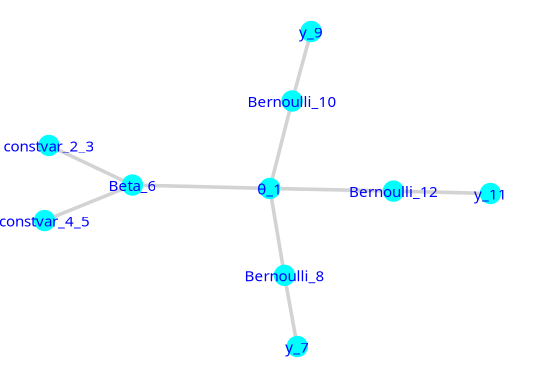

In [7]:
GraphPlot.gplot(
    meta_graph,
    layout=spring_layout,
    nodelabel=collect(labels(meta_graph)),
    nodelabelsize=1.0,
    NODESIZE=0.05, # diameter of the nodes,
    nodelabelc="blue",
    nodelabeldist=0.0,
    nodefillc="cyan",
)

# Querying The Structure of The Graph

## Contexts

After creating a GraphPPL.Model structure, it is important to know about the attached Context. The Context structure contains all variable and factor nodes in the scope of the model, and contains a Context stucture for all submodels. The context of a model can be accessed by the ```GraphPPL.getcontext()``` function:

In [12]:
fieldnames(GraphPPL.Context)

(:depth, :fform, :prefix, :parent, :submodel_counts, :children, :factor_nodes, :individual_variables, :vector_variables, :tensor_variables, :proxies, :returnval)

In [42]:
gppl_model_context = GraphPPL.getcontext(gppl_model)

Context()
 Individual variables: {:constvar_2, :θ, :constvar_4}
 Vector variables: {:y}
 Tensor variables: {}
 Proxies: {}
 Factor nodes: GraphPPL.FactorID[(Bernoulli, 1), (Bernoulli, 2), (Bernoulli, 3), (Beta, 1)]


In [172]:
function gppl_global_context_info(model::GraphPPL.Model)
    
    context = GraphPPL.getcontext(model)
    
    println("Individual variables: ", context.individual_variables)
    println("Vector variables: ", context.vector_variables)
    println("Tensor variables: ", context.tensor_variables)
    println("Proxies: ", context.proxies)
    println("Factor nodes: ", context.factor_nodes)
    println("Depth: ", context.depth)
    println("Prefix: ", context.prefix)
    println("Parent: ", context.parent)
    println("Submodel counts: ", context.submodel_counts)
    println("Children: ", context.children)
    println("Returnval: ", context.returnval)
    println("------------------------------------- Factor Nodes -------------------------------------")
    
    for factor_node in context.factor_nodes
        node_data = model[factor_node]
        println("Factor Node: ", factor_node)
        println("  Form: ", node_data.properties.fform)
        println("  Neighbors:")
        for (label, edge, neighbor) in node_data.properties.neighbors
            println("    - Label: ", label)
            println("      Edge: ", edge)
            println("      Neighbor: ", neighbor)
            println("      Type of Neighbor: ", typeof(neighbor))
            println()
        end
    end
end

gppl_global_context_info (generic function with 1 method)

In [173]:
gppl_global_context_info(gppl_model)

Individual variables: {:constvar_2 = constvar_2_3, :θ = θ_1, :constvar_4 = constvar_4_5}
Vector variables: {:y = ResizableArray{GraphPPL.NodeLabel,1}(GraphPPL.NodeLabel[y_7, y_9, y_11])}
Tensor variables: {}
Proxies: {}
Factor nodes: {(Bernoulli, 1) = Bernoulli_8, (Bernoulli, 2) = Bernoulli_10, (Bernoulli, 3) = Bernoulli_12, (Beta, 1) = Beta_6}
Depth: 0
Prefix: 
Parent: nothing
Submodel counts: {Bernoulli = 3, Beta = 1}
Children: {}
Returnval: Base.RefValue{Any}(nothing)
------------------------------------- Factor Nodes -------------------------------------
Factor Node: Bernoulli_8
  Form: Bernoulli
  Neighbors:
    - Label: y_7
      Edge: out
      Neighbor: NodeData in context  with properties name = y, index = 1
      Type of Neighbor: GraphPPL.NodeData

    - Label: θ_1
      Edge: p
      Neighbor: NodeData in context  with properties name = θ, index = nothing
      Type of Neighbor: GraphPPL.NodeData

Factor Node: Bernoulli_10
  Form: Bernoulli
  Neighbors:
    - Label: y_9
   

In [44]:
for (factor_ID, factor_label) in pairs(gppl_model_context.factor_nodes)
#     println("$(factor_ID), $(factor_label)")
#     println("$(typeof(factor_ID)), $(typeof(factor_label))")
    node_data = gppl_model[factor_label]
    println("$(node_data.properties.fform)\n")
end

Bernoulli

Bernoulli

Bernoulli

Beta



In [45]:
gppl_model_context.factor_nodes

4-element UnorderedDictionary{GraphPPL.FactorID, GraphPPL.NodeLabel}
 (Bernoulli, 1) │ Bernoulli_8
 (Bernoulli, 2) │ Bernoulli_10
 (Bernoulli, 3) │ Bernoulli_12
      (Beta, 1) │ Beta_6

# Current GraphViz Functionality Demo

# Coin-toss Model

In this example, we are going to perform an exact inference for a coin-toss model that can be represented as:

\begin{align}
    p(\theta) &= \text{Beta}(\theta | a, b)\\
    p(y_i | \theta) &= \text{Bernoulli}(y_i | \theta)
\end{align}

Where $y_i \in \{0, 1\}$ is a binary observation induced by Bernoulli likelihood while $\theta$ is a Beta prior distribution on the parameter of the Bernoulli Likelihood. We are interested in inferring the posterior distribution of $\theta$.

The joint probability is given by the multiplication of the likelihood and the prior, i.e.

\begin{equation}
    p(y_{1:N}, \theta) = p(\theta) \prod_{i=1}^{N} p(y_i | \theta)
\end{equation}

We can specify this model (the joint distribution) using GraphPPL's package syntax.

In [174]:
# GraphPPL.jl export `@model` macro for model specification
# It accepts a regular Julia function and builds an FFG under the hood
@model function coin_model(y, a, b)
    # We endow θ parameter of our model with some prior
    θ ~ Beta(a, b)
    # or, in this particular case, the `Uniform(0.0, 1.0)` prior also works:
    # θ ~ Uniform(0.0, 1.0)

    # We assume that outcome of each coin flip is governed by the Bernoulli distribution
    for i in eachindex(y)
        y[i] ~ Bernoulli(θ)
    end
end

In [175]:
# `Create` the actual graph of the model conditioned on the data
rxi_model = RxInfer.create_model(conditioned);

In [176]:
gppl_model = RxInfer.getmodel(rxi_model);

In [177]:
# Extract the MetaGraphsNext graph
meta_graph = gppl_model.graph;

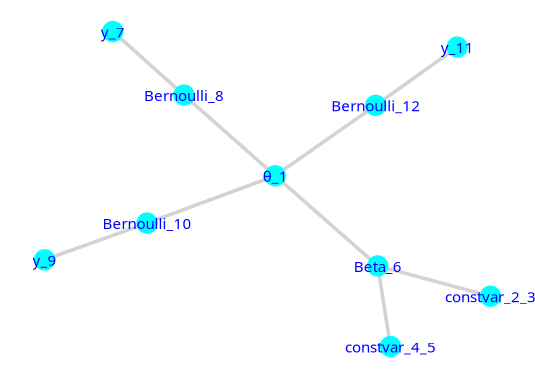

In [178]:
# The existing plotting functionality:
GraphPlot.gplot(
    meta_graph,
    layout=spring_layout,
    nodelabel=collect(labels(meta_graph)),
    nodelabelsize=1.0,
    NODESIZE=0.05, # diameter of the nodes,
    nodelabelc="blue",
    nodelabeldist=0.0,
    nodefillc="cyan",
)

# Potentail Taxicab Layout 

In [212]:
MetaGraphsNext.nv(meta_graph)

10

In [216]:
MetaGraphsNext.vertices(meta_graph)

Base.OneTo(10)

# GraphViz DOT Code Generation and Visualisation (P.O.C)

In [202]:
"""
Parses the input GraphPPL.Model and uses Base.IOBuffer to 
iteratively construct a Julia string,containing the DOT 
code for the GraphViz visualisation of the graph. This 
string is then returned. 

Currently isomorphic to the display given by GraphPlot.gplot.
"""
function generate_dot(; 
        Model::GraphPPL.Model, font_size::Int, 
        edge_length::Float64 = 1.0, layout::String="neato", 
        width::Float64=10.0, height::Float64=10.0,
    )
    
    meta_graph = Model.graph # underlying MetaGraphsNext graph
    
    io_buffer = IOBuffer() # use Base.IOBuffer rather than sucessive string concatenation
    
    write(io_buffer, "dot\"\"\"\ngraph G {\n")
    write(io_buffer, "    layout=$(layout);\n")
    write(io_buffer, "    size=\"$(width),$(height)!\";\n")
    write(io_buffer, "    node [shape=circle, fontsize=$(font_size)];\n") # write initial graph DOT code to the Base.IOBuffer
    
    # Vertices/Nodes
    for vertex in MetaGraphsNext.vertices(meta_graph)
        label = MetaGraphsNext.label_for(meta_graph, vertex)
        
        properties = Model[label].properties # for dsistnguishing factor/variable nodes
        
        if isa(properties, GraphPPL.FactorNodeProperties) # Factor node
            write(io_buffer, "    \"$(label)\" [shape=square, style=filled, fillcolor=lightgray];\n")
        elseif isa(properties, GraphPPL.VariableNodeProperties) # Variable Node
            write(io_buffer, "    \"$(label)\" [shape=circle];\n")
        else
            println("ERROR: Unknown node type for label $(label)")
        end
    end
    
    # Edges
    for edge in MetaGraphsNext.edges(meta_graph)
        source_vertex = MetaGraphsNext.label_for(meta_graph, edge.src)
        dest_vertex = MetaGraphsNext.label_for(meta_graph, edge.dst)
        write(io_buffer, "    \"$(source_vertex)\" -- \"$(dest_vertex)\" [len=$(edge_length)];\n")
    end
    
    write(io_buffer, "}\n\"\"\"")
    
    final_dot_code = String(take!(io_buffer))
    
    return final_dot_code
    
end

generate_dot

In [180]:
"""
Takes the DOT string given by generate_dot and 
executes it to produce a GraphViz visualisation. 
"""
function show_gv(dot_code_graph::String)
    eval(Meta.parse(dot_code_graph))
end

show_gv

In [183]:
# create the DOT code string
coin_toss_dot = generate_dot(
    Model = gppl_model, 
    font_size = 7,
    edge_length = 1.0,
    layout = "neato",
    width = 10.0,
    height = 10.0
);

In [150]:
# Optionally write the DOT string to a file:
# file_name = "coin_toss_graph.dot"

# open(file_name, "w") do file
#     write(file, coin_toss_dot)
# end

903

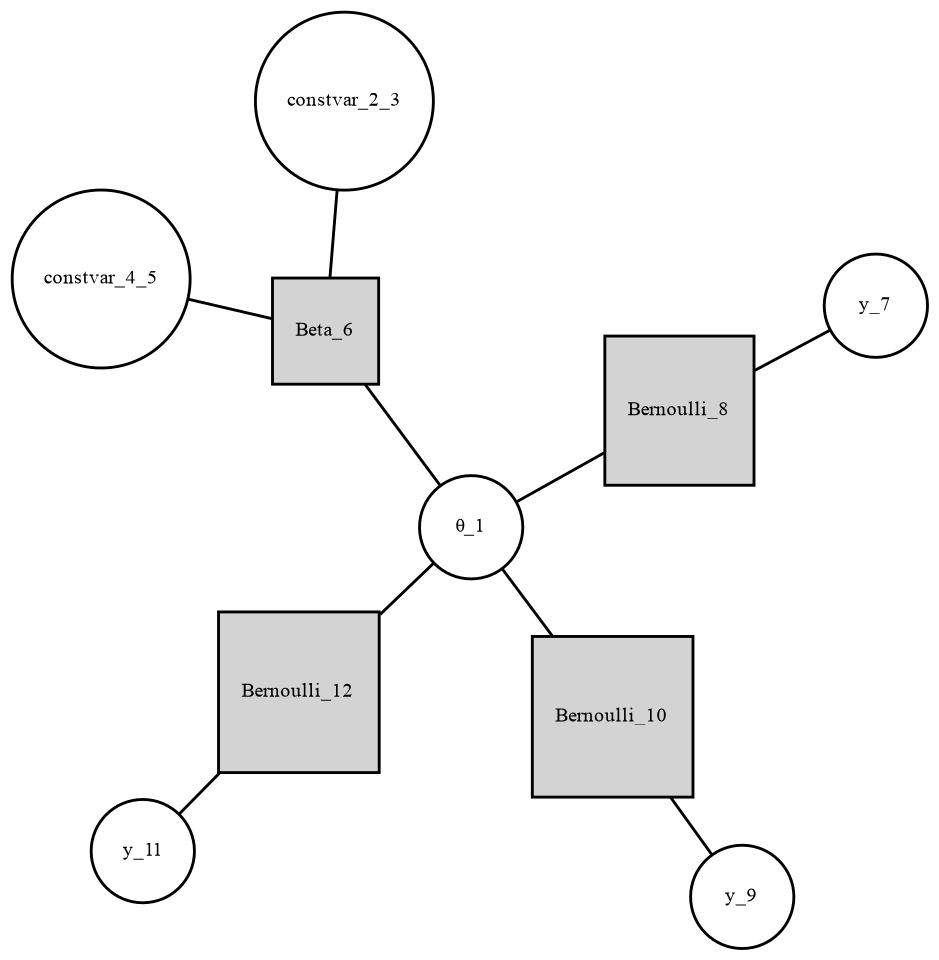

In [184]:
# execute the DOT code string
show_gv(coin_toss_dot)

# Linear Regression Model

In [185]:
function generate_data(a, b, v, nr_samples; rng=StableRNG(1234))
    x = float.(collect(1:nr_samples))
    y = a .* x .+ b .+ randn(rng, nr_samples) .* sqrt(v)
    return x, y
end;

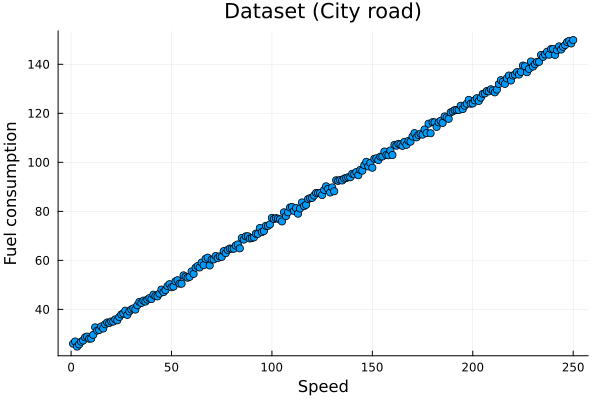

In [186]:
x_data, y_data = generate_data(0.5, 25.0, 1.0, 250)

scatter(x_data, y_data, title = "Dataset (City road)", legend=false)
xlabel!("Speed")
ylabel!("Fuel consumption")

In [187]:
@model function linear_regression(x, y)
    a ~ Normal(mean = 0.0, variance = 1.0)
    b ~ Normal(mean = 0.0, variance = 100.0)    
    y .~ Normal(mean = a .* x .+ b, variance = 1.0)
end

In [188]:
# Prepare the data
x_data = [1.0, 2.0, 3.0, 4.0, 5.0]  # example input data
y_data = [2.0, 4.1, 6.2, 8.3, 10.4];  # example observed data

In [189]:
linr_conditioned = linear_regression() | (x = x_data, y = y_data, );

In [190]:
# Create the RxInfer model and inject the data
linr_rxi_model = GraphPPL.create_model(linr_conditioned);

In [191]:
# Extract the GraphPPL.Model
linr_gppl_model = RxInfer.getmodel(linr_rxi_model);

In [192]:
# Extract the MetaGraphsNext meta graph
linr_meta_graph = linr_gppl_model.graph;

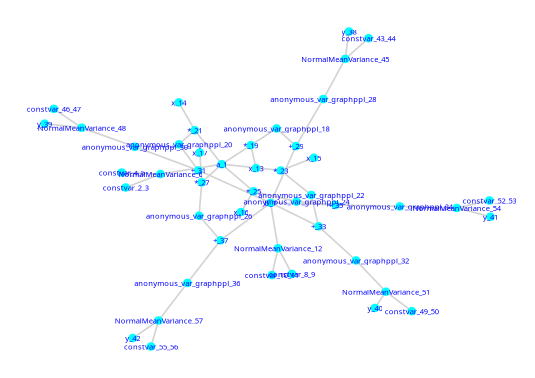

In [193]:
# The existing plotting functionality:
GraphPlot.gplot(
    linr_meta_graph,
    layout=spring_layout,
    nodelabel=collect(labels(linr_meta_graph)),
    nodelabelsize=0.1,
    NODESIZE=0.02, # diameter of the nodes,
    NODELABELSIZE=2,
    nodelabelc="blue",
    nodelabeldist=0.0,
    nodefillc="cyan"
)

In [194]:
# create the DOT code string
linr_model_dot = generate_dot(
    Model = linr_gppl_model,
    font_size = 10,
    edge_length = 2.5,
    layout = "neato",
    width = 8.0,
    height = 8.0
);

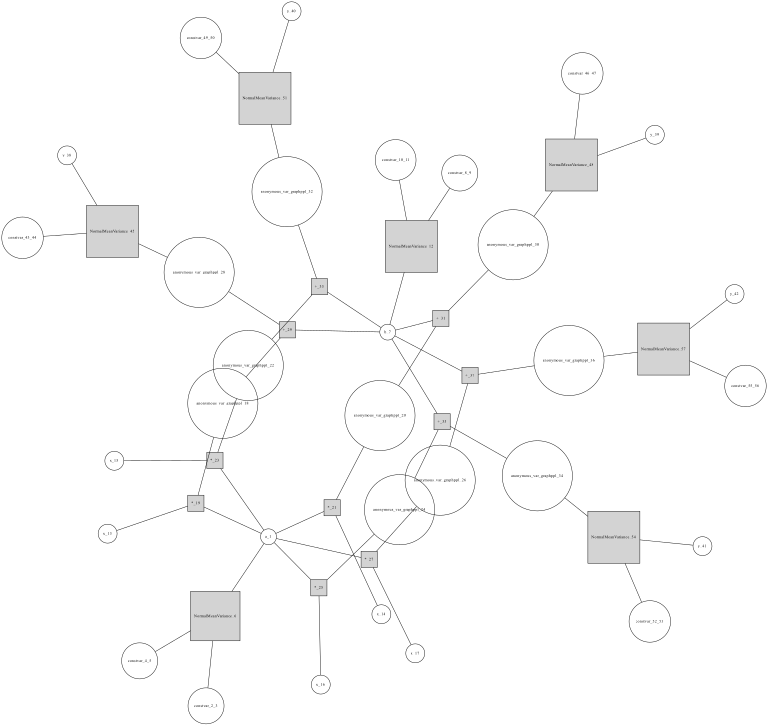

In [195]:
# execute the DOT code string
show_gv(linr_model_dot)

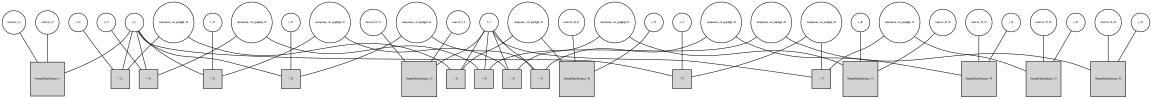

In [199]:
# Use a different graphViz layout engine: "dot"
linr_model_dot_2 = generate_dot(
    Model = linr_gppl_model,
    font_size = 5,
    edge_length = 2.5,
    layout = "dot",
    width = 12.0,
    height = 12.0
);

# execute the DOT code string
show_gv(linr_model_dot_2)

# Experimentation with Other Features (Highy Disorganised):

# Tikz/PGF

In [23]:
preamble = """\\documentclass{standalone}
\\usepackage{tikz}
\\usetikzlibrary{graphs,graphdrawing,quotes}
\\usegdlibrary{force}

\\begin{document}
\\begin{tikzpicture}
  \\graph [spring layout, node distance=20mm,
 nodes={draw, circle, fill=blue, text=white},
  edge quotes={fill=yellow, inner sep=2pt}]
  {\n"""

postamble = """};
\\end{tikzpicture}
\\end{document}"""

G = meta_graph

tex_code = preamble

for vertex in MetaGraphsNext.vertices(G)
    tex_code *= "    $(vertex) [as={\$n_{$(vertex)}\$}];\n"
end

for edge in MetaGraphsNext.edges(G)
    source_vertex = MetaGraphsNext.label_for(G, edge.src)
    dest_vertex = MetaGraphsNext.label_for(G, edge.dst)
    tex_code *= "    $(source_vertex) -- $(dest_vertex);\n"
end

tex_code *= postamble

# Write the TikZ code to a .tex file
file_path = "tikz_graph.tex"
open(file_path, "w") do file
    write(file, tex_code)
end

772

In [54]:
for edge in MetaGraphsNext.edges(meta_graph)
    println("$(edge.src)")
    println("$(MetaGraphsNext.label_for(meta_graph, edge.src))\n")
#     dot_code *= "    $(edge.src) -> $(edge.dst);"
end

1
θ_1

1
θ_1

1
θ_1

1
θ_1

2
constvar_2_3

3
constvar_4_5

5
y_7

7
y_9

9
y_11



In [55]:
for edge in MetaGraphsNext.edges(meta_graph)
    println("$(edge.dst)")
    println("$(MetaGraphsNext.label_for(meta_graph, edge.src))\n")
#     dot_code *= "    $(edge.src) -> $(edge.dst);"
end

4
Beta_6

6
Bernoulli_8

8
Bernoulli_10

10
Bernoulli_12

4
Beta_6

4
Beta_6

6
Bernoulli_8

8
Bernoulli_10

10
Bernoulli_12



In [27]:
typeof(MetaGraphsNext.edges(meta_graph))

Graphs.SimpleGraphs.SimpleEdgeIter{Graphs.SimpleGraphs.SimpleGraph{Int64}}

In [33]:
MetaGraphsNext.label_for(meta_graph, 1)

GraphPPL.NodeLabel

In [39]:
for i in 1:length(collect(labels(meta_graph)))
    println(MetaGraphsNext.label_for(meta_graph, i))
end

θ_1
constvar_2_3
constvar_4_5
Beta_6
y_7
Bernoulli_8
y_9
Bernoulli_10
y_11
Bernoulli_12


In [40]:
collect(labels(meta_graph))

10-element Vector{GraphPPL.NodeLabel}:
 θ_1
 constvar_2_3
 constvar_4_5
 Beta_6
 y_7
 Bernoulli_8
 y_9
 Bernoulli_10
 y_11
 Bernoulli_12

In [44]:
for vertex in MetaGraphsNext.vertices(meta_graph)  # add nodes
    println(MetaGraphsNext.label_for(meta_graph, vertex))
end

θ_1
constvar_2_3
constvar_4_5
Beta_6
y_7
Bernoulli_8
y_9
Bernoulli_10
y_11
Bernoulli_12


# Old Functionality (String Concat)

In [151]:
"""
A helper function to wrap GraphViz DOT code in the 
command string used with GraphViz.jl 
"""
function wrap_dot_code(dot_code::String)
    return "dot\"\"\"\n$dot_code\n\"\"\""
end

wrap_dot_code

In [169]:
"""
Basic visualisation of a GraphPPL.Model with GraphViz.
Isomorphic to the display given by GraphPlot.gplot.
"""
function show_gv_V2(; Model::GraphPPL.Model, font_size::Int, edge_length::Float64 = 1.0)
    
    meta_graph = Model.graph # underlying MetaGraphsNext graph
    
    
    dot_code = """
    graph G {
        node [shape=circle, fontsize=$(font_size)];
    """
    
    # Vertices/Nodes
    for vertex in MetaGraphsNext.vertices(meta_graph)
        label = MetaGraphsNext.label_for(meta_graph, vertex)
        
        properties = Model[label].properties # for dsistnguishing factor/variable nodes
        
        if isa(properties, GraphPPL.FactorNodeProperties) # Factor node
            dot_code *= "    \"$(label)\" [shape=square, style=filled, fillcolor=lightgray];\n"
        elseif isa(properties, GraphPPL.VariableNodeProperties) # Variable Node
            dot_code *= "    \"$(label)\" [shape=circle];\n"
        else
            println("ERROR: Unknown node type for label $(label)")
        end
    end
    
    # Edges
    for edge in MetaGraphsNext.edges(meta_graph)
        source_vertex = MetaGraphsNext.label_for(meta_graph, edge.src)
        dest_vertex = MetaGraphsNext.label_for(meta_graph, edge.dst)
        dot_code *= "    \"$(source_vertex)\" -- \"$(dest_vertex)\" [len=$(edge_length)];\n"
    end
    
    dot_code *= "}"

    wrapped_dot_code = wrap_dot_code(dot_code)
    
    eval(Meta.parse(wrapped_dot_code)) # not ideal, but used for this example
end

show_gv_V2

In [170]:
"""
Basic visualisation a GraphPPL.Model with GraphViz.
Isomorphic to the display given by GraphPlot.gplot.
"""
function show_gv_OG(; Model::GraphPPL.Model, font_size::Int)
    
    meta_graph = Model.graph # underlying MetaGraphsNext graph
    
    dot_code = """
    graph G {
        node [shape=circle, fontsize=$(font_size)];
    """

#     for vertex in MetaGraphsNext.vertices(G)  # add nodes
#         dot_code *="    $(MetaGraphsNext.label_for(G, vertex));\n"
#     end
    
    for vertex in MetaGraphsNext.vertices(meta_graph)
        label = MetaGraphsNext.label_for(meta_graph, vertex)
        if isa(Model[label].properties, GraphPPL.FactorNodeProperties{GraphPPL.NodeData})
            dot_code *="    $(MetaGraphsNext.label_for(meta_graph, vertex)) [shape=square];\n"
        elseif isa(Model[label].properties, GraphPPL.VariableNodeProperties{GraphPPL.NodeData})
            dot_code *="    $(MetaGraphsNext.label_for(meta_graph, vertex)) [shape=circle];\n"
        else
            println("ERROR")
        end
    end
    
#     for (factor_id, node_label) in pairs(gppl_model_context.factor_nodes)
#         # get vertex code from the meta graph
#         # test if this vertex code belongs to a node factor 
#         #     if yes, make this node's shape square
#         println("TESTING")
#     end

    for edge in MetaGraphsNext.edges(meta_graph)  # add edges
        source_vertex = MetaGraphsNext.label_for(meta_graph, edge.src)
        dest_vertex = MetaGraphsNext.label_for(meta_graph, edge.dst)
        dot_code *= "    $(source_vertex) -- $(dest_vertex);\n"
    end
    
    dot_code *= "}"

    wrapped_dot_code = wrap_dot_code(dot_code)
    
    eval(Meta.parse(wrapped_dot_code)) # not ideal 

end

show_gv_OG